### Predicting Movie  Statistics Classification  

This notebook is based on a case study on the Edx course: Using Python for Research 

The [movie dataset on which this case study is based](https://www.kaggle.com/tmdb/tmdb-movie-metadata) is a database of 5000 movies catalogued by [The Movie Database (TMDb)](https://www.themoviedb.org/?language=en). The information available about each movie is its budget, revenue, rating, actors and actresses, etc. In this case study, we will use this dataset to determine whether any information about a movie can predict the total revenue of a movie. We will also attempt to predict whether a movie's revenue will exceed its budget.

First, we inspect, clean, and transform the data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

df = pd.read_csv("https://courses.edx.org/asset-v1:HarvardX+PH526x+2T2019+type@asset+block@movie_data.csv", index_col=0)


In [2]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


In [35]:
df.shape

(4803, 22)

### Data Cleaning

For simplicity, we will proceed by analyzing only the rows without any missing data. In this exercise, we will remove rows with any infinite or missing values.

In [3]:
#replace missing values with np.nan
df.replace((np.inf,-np.inf ),np.nan)
df.dropna( inplace=True)

In [4]:
df.shape

(1406, 22)

In [5]:
df.isnull().sum()

budget                  0
genres                  0
homepage                0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
movie_id                0
cast                    0
dtype: int64

### Data Transformation

We define the regression and classification outcomes. Specifically, we will use the `revenue` column as the target for regression. For classification, we will construct an indicator of profitability for each movie.

#### Instructions 
- Create a new column in `df` called `profitable`,defined as 1 if the movie `revenue` is greater than the movie `budget`, and 0 otherwise.
- Store the outcomes to be used for regression and classification.
    - Define `regression_target` as the string `'revenue'`.
    - Define `classification_target` as the string `'profitable'`.

In [6]:
df['profitable'] = np.where(df['revenue'] >= df['budget'], 1, 0)
df.head(5)

regression_target = 'revenue'
classification_target = 'profitable'



Since many of the variables in our dataframe contain the names of genre, actors/actresses, and keywords. Let's add indicator columns for each genre such that each element of these genre columns should be 1 if the movie belongs to that particular genre, and 0 otherwise. Keep in mind, a movie may belong to several genres at once.



In [7]:
#using get_dummies
df = pd.concat([df, df['genres'].str.get_dummies(sep=',')], axis=1)

In [8]:
df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,0,0,0,0,0,0,0,0,0,0
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,0,0,0,0,0,0,0,0,0,0
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,0,0,0,0,0,0,0,0,0,0
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,0,0,0,0,0,0,0,0,0,0
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,4000000,"Thriller, Science Fiction",https://www.facebook.com/thesignalfilm,242095,"hacker, supernatural powers, road trip, indepe...",en,The Signal,Three college students on a road trip across t...,27.662696,"Automatik Entertainment, Low Spark Films, Sign...",...,0,0,0,0,0,0,0,1,0,0
4766,0,"Documentary, Music",http://www.mgm.com/#/our-titles/1092/The-Last-...,13963,"1970s, music",en,The Last Waltz,Martin Scorsese's rockumentary intertwines foo...,3.277287,"FM Productions, Last Waltz Inc.",...,0,0,0,0,0,0,0,0,0,0
4773,27000,Comedy,http://www.miramax.com/movie/clerks/,2292,"salesclerk, loser, aftercreditsstinger",en,Clerks,Convenience and video store clerks Dante and R...,19.748658,"Miramax Films, View Askew Productions",...,0,0,0,0,0,0,0,0,0,0
4791,13,Horror,http://tincanmanthemovie.com/,157185,home invasion,en,Tin Can Man,Recently dumped by his girlfirend for another ...,0.332679,"Park Films, Camera Stylo Films",...,0,1,0,0,0,0,0,0,0,0


In [9]:
df['genres'].head()

0    Action, Adventure, Fantasy, Science Fiction
1                     Adventure, Fantasy, Action
2                       Action, Adventure, Crime
3                 Action, Crime, Drama, Thriller
4             Action, Adventure, Science Fiction
Name: genres, dtype: object



Some variables in the dataset are already numeric and perhaps useful for regression and classification. We will take a look at some of the continuous variables and outcomes by plotting each pair in a scatter plot. Finally, we will evaluate the skew of each variable.


In [10]:
continuous_covariates = ['budget', 'popularity', 'runtime', 'vote_count', 'vote_average']
outcomes_and_continuous_covariates = continuous_covariates + [regression_target, classification_target]


Which of the covariates and/or outcomes are correlated with each other?

In [11]:
df[outcomes_and_continuous_covariates].corr(method='pearson')

,budget,popularity,runtime,vote_count,vote_average,revenue,profitable
budget,1.000000,0.439311,0.361966,0.593310,0.056981,0.738774,0.185371
popularity,0.439311,1.000000,0.287424,0.712211,0.295903,0.583981,0.242929
runtime,0.361966,0.287424,1.000000,0.443413,0.384917,0.379976,0.132039
vote_count,0.593310,0.712211,0.443413,1.000000,0.431917,0.778908,0.310122
vote_average,0.056981,0.295903,0.384917,0.431917,1.000000,0.245249,0.265907
revenue,0.738774,0.583981,0.379976,0.778908,0.245249,1.000000,0.318632
profitable,0.185371,0.242929,0.132039,0.310122,0.265907,0.318632,1.000000


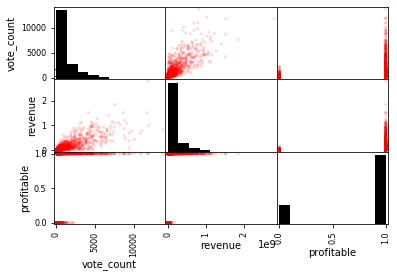

In [12]:
plotting_variables = ['vote_count', regression_target, classification_target]
axes = pd.plotting.scatter_matrix(df[plotting_variables], alpha=0.15, \
       color=(0,0,0), hist_kwds={"color":(0,0,0)}, facecolor=(1,0,0))
# show the plot.
plt.show()

Is the skew above 1 for any of these variables?

In [13]:
# determine the skew.
df[outcomes_and_continuous_covariates].skew()

budget          1.754872
popularity      7.968139
runtime         1.059804
vote_count      2.461041
vote_average   -1.080038
revenue         3.084680
profitable     -1.385303
dtype: float64

It appears that the variables `budget`, `popularity`, `runtime`, `vote_count`, and `revenue` are all positively-skewed.  we will transform these variables to eliminate this skewness. Specifically, we will use the `np.log10()` method. Because some of these variable values are exactly 0, we will add a small positive value to each to ensure it is defined; this is necessary because log(0) is negative infinity.


In [14]:
#Normalize variables remove the positive-skewness by carrying out a log transformation.
variables_to_be_transformed =  ['budget', 'popularity', 'runtime', 'vote_count','revenue']
transformed_df= np.log10(1 + (df[variables_to_be_transformed]))        

#Update df with the transformed columns
df.update(transformed_df)

In [15]:
df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,8.374748,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",2.180234,"Ingenious Film Partners, Twentieth Century Fox...",...,0,0,0,0,0,0,0,0,0,0
1,8.477121,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",2.146384,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,0,0,0,0,0,0,0,0,0,0
2,8.389166,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,2.034936,"Columbia Pictures, Danjaq, B24",...,0,0,0,0,0,0,0,0,0,0
3,8.397940,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,2.054280,"Legendary Pictures, Warner Bros., DC Entertain...",...,0,0,0,0,0,0,0,0,0,0
4,8.414973,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",1.652507,Walt Disney Pictures,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,6.602060,"Thriller, Science Fiction",https://www.facebook.com/thesignalfilm,242095,"hacker, supernatural powers, road trip, indepe...",en,The Signal,Three college students on a road trip across t...,1.457317,"Automatik Entertainment, Low Spark Films, Sign...",...,0,0,0,0,0,0,0,1,0,0
4766,0.000000,"Documentary, Music",http://www.mgm.com/#/our-titles/1092/The-Last-...,13963,"1970s, music",en,The Last Waltz,Martin Scorsese's rockumentary intertwines foo...,0.631168,"FM Productions, Last Waltz Inc.",...,0,0,0,0,0,0,0,0,0,0
4773,4.431380,Comedy,http://www.miramax.com/movie/clerks/,2292,"salesclerk, loser, aftercreditsstinger",en,Clerks,Convenience and video store clerks Dante and R...,1.316990,"Miramax Films, View Askew Productions",...,0,0,0,0,0,0,0,0,0,0
4791,1.146128,Horror,http://tincanmanthemovie.com/,157185,home invasion,en,Tin Can Man,Recently dumped by his girlfirend for another ...,0.124726,"Park Films, Camera Stylo Films",...,0,1,0,0,0,0,0,0,0,0


### Data Modelling

We will primarily use two models linear/logistic regression and random forests to perform prediction and classification. We will use these methods to predict revenue, and we will use logistic regression to classify whether a movie was profitable.

In [16]:
# Define all covariates and outcomes from `df`.
regression_target = 'revenue'
classification_target = 'profitable'
all_covariates = ['budget', 'popularity', 'runtime', 'vote_count', 'vote_average', 'Action', 'Adventure', 'Fantasy', 
                  'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy', 'Romance', 
                  'Horror', 'Mystery', 'War', 'History', 'Music', 'Documentary', 'TV Movie', 'Foreign']

regression_outcome = df[regression_target]
classification_outcome = df[classification_target]
covariates = df[all_covariates]

# Instantiate all regression models and classifiers.
linear_regression = LinearRegression()
logistic_regression = LogisticRegression()
forest_regression = RandomForestRegressor(max_depth=4,random_state=0)
forest_classifier = RandomForestClassifier(max_depth=4,random_state=0)

We will create two functions that compute a model's score. For regression models, we will use correlation as the score. For classification models, we will use accuracy as the score.

We define a function called correlation with arguments estimator, X, and y. The function should compute the correlation between the observed outcome y and the outcome predicted by the model by returning the `r2_score`  for regression and `accuracy_score` for classification.

In [17]:
def correlation(estimator, X, y):
    predictions = estimator.fit(X, y).predict(X)
    return r2_score(y, predictions)

In [18]:
def accuracy(estimator, X, y):
    prediction = estimator.fit(X, y).predict(X)
    return accuracy_score(y, prediction)

Every estimator exposes a score method that can judge the quality of the fit (or the prediction) on new data.Knowing this we call cross_val_score using linear_regression and forest regression as models. Store the output as linear_regression_scores and forest_regression_scores, respectively, then plot the result.

In [19]:
from sklearn.model_selection import cross_val_score

# Determine the cross-validated correlation for linear and random forest models.
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome,cv=10, scoring=correlation)

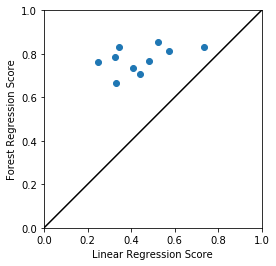

In [20]:
# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(linear_regression_scores, forest_regression_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Regression Score")
plt.ylabel("Forest Regression Score")

# Show the plot.
plt.show()

Next we repeat the above process by computing the cross-validated performance for the linear and random forest classification models,using logistic_regression and forest_classifier as models and storing the output as logistic_regression_scores and forest_classification_scores, respectively.

In [21]:
# Determine the cross-validated accuracy for logistic and random forest models.
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome,cv=10, scoring=accuracy)

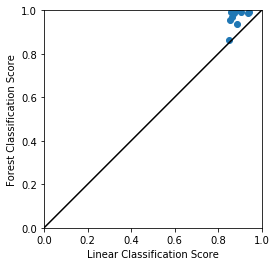

In [22]:
# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")
# Show the plot.
plt.show()

We can see that predicting revenue was only moderately successful. It might be the case that predicting movies that generated precisely no revenue is difficult. Hence, we will exclude these movies, and rerun the analyses to determine if the fits improve.

In [23]:
positive_revenue_df = df[df['revenue']>0]

# Replace the dataframe in the following code, and run.

regression_outcome = positive_revenue_df[regression_target]
classification_outcome = positive_revenue_df[classification_target]
covariates = positive_revenue_df[all_covariates]

# Reinstantiate all regression models and classifiers.
linear_regression = LinearRegression()
logistic_regression = LogisticRegression()
forest_regression = RandomForestRegressor(max_depth=4, random_state=0)
forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

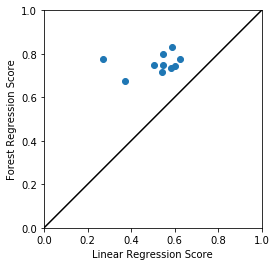

In [24]:
# Determine the cross-validated correlation for linear and random forest models.
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(linear_regression_scores, forest_regression_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Regression Score")
plt.ylabel("Forest Regression Score")
# Show the plot.
plt.show()

In [25]:
# Print the importance of each covariate in the random forest regression.
forest_regression.fit(covariates, regression_outcome)    
sorted(list(zip(all_covariates, forest_regression.feature_importances_)), key=lambda tup: tup[1])

[('Action', 0.0),
 ('Fantasy', 0.0),
 ('Family', 0.0),
 ('Mystery', 0.0),
 ('War', 0.0),
 ('Music', 0.0),
 ('Documentary', 0.0),
 ('TV Movie', 0.0),
 ('Drama', 3.4271202031985406e-06),
 ('Foreign', 1.9735563746096944e-05),
 ('Thriller', 5.411737600051032e-05),
 ('Animation', 7.668797127020687e-05),
 ('History', 9.302998292583077e-05),
 ('Comedy', 0.00011454941470388593),
 ('Romance', 0.00011657956607686142),
 ('Western', 0.00015612802611948123),
 ('Horror', 0.00019162554318328417),
 ('Crime', 0.00043563542042641197),
 ('Science Fiction', 0.0006922989188754787),
 ('Adventure', 0.0012624306246218216),
 ('vote_average', 0.007373449034111552),
 ('runtime', 0.01853912441575444),
 ('popularity', 0.08286485474960262),
 ('budget', 0.30934477885402767),
 ('vote_count', 0.5786615474183507)]

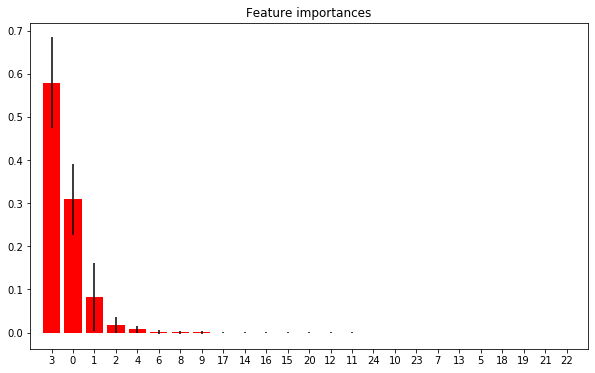

In [26]:
#plot view of  the importance of each covariates in the random forest regression

forest_regression.fit(covariates, regression_outcome) 
importance = forest_regression.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest_regression.estimators_],axis=0)
indices = np.argsort(importance)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(10,6))
plt.title("Feature importances")
n= len(all_covariates)
_ = plt.bar(range(n), importance[indices][:n], color="r", yerr=std[indices][:n])
plt.xticks(range(n), indices)
plt.xlim([-1, n])
plt.show()

In predicting revenue using the random forests classifier  vote_count, budget and popularity which are the three most important variable.

We also rerun the analysis to compute the cross-validated performance for the linear and random forest classification models for positive revenue movies only.

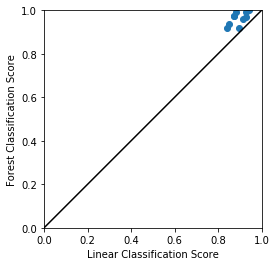

In [27]:
# Determine the cross-validated accuracy for logistic and random forest models.
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

# Show the plot.
plt.show()

In [28]:
# Print the importance of each covariate in the random forest classification.
forest_classifier.fit(covariates, classification_outcome)
sorted(list(zip(all_covariates, forest_classifier.feature_importances_)), key=lambda tup: tup[1])

[('TV Movie', 0.0),
 ('Western', 2.0522445511460278e-07),
 ('History', 0.00023611013902951591),
 ('Music', 0.0002676286098882071),
 ('Family', 0.0014792963518621062),
 ('Crime', 0.0018162528335182182),
 ('Science Fiction', 0.001986945952407334),
 ('Horror', 0.002458999829746034),
 ('Mystery', 0.0025630331010164514),
 ('Adventure', 0.002843955222519881),
 ('Thriller', 0.0029387578881161338),
 ('Romance', 0.0030375374172164436),
 ('Animation', 0.0031702198791260473),
 ('Foreign', 0.003459376239904329),
 ('Fantasy', 0.005031436972783813),
 ('Comedy', 0.005253595233976837),
 ('Drama', 0.005997037343047244),
 ('Documentary', 0.006387125256377976),
 ('Action', 0.006478384005030661),
 ('War', 0.014277721147728264),
 ('runtime', 0.04452004486687465),
 ('budget', 0.11335303438124705),
 ('vote_average', 0.11714282982089667),
 ('popularity', 0.2896549355204085),
 ('vote_count', 0.36564553676282247)]

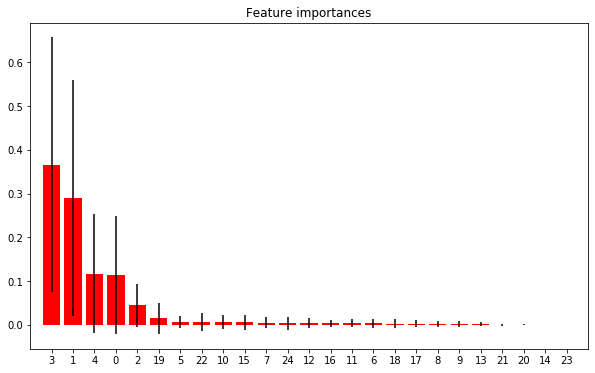

In [30]:
#plot view of  the importance of each covariates in the random forest classifier

forest_classifier.fit(covariates, classification_outcome) 
importance = forest_classifier.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest_classifier.estimators_],axis=0)
indices = np.argsort(importance)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(10,6))
plt.title("Feature importances")
n= len(all_covariates)
_ = plt.bar(range(n), importance[indices][:n], color="r", yerr=std[indices][:n])
plt.xticks(range(n), indices)
plt.xlim([-1, n])
plt.show()

However in predicting whether a movie is profitable or not, four  variables are important; vote_count,popularity,budget and vote average.